# Description

* Demand Forecast is one of the key tasks in Supply Chain and Retail Domain in general. It is key in effective operation and optimization of retail supply chain. Effectively solving this problem requires knowledge about a wide range of tricks in Data Sciences and good understanding of ensemble techniques.


* Training Data Description: Historic sales at Store-Day level for about two years for a retail giant, for more than 1000 stores. Also, other sale influencers like, whether on a particular day the store was fully open or closed for renovation, holiday and special event details, are also provided. 


### import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import math

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers
from keras.optimizers import Adam,RMSprop,SGD,Adagrad
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor

### Project Task: Week 1

### Exploratory Data Analysis (EDA) and Linear Regression:

In [2]:
train_data = pd.read_csv(r'D:\Simplilearn\project\Artificial-Intelligence-Capstone-Project-Datasets-master\Project 3-Retail-Datasets_data\train_data.csv')
train_data.Date = pd.to_datetime(train_data.Date)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2015-06-30,5735,568,1,1,0,0
1,2,2,2015-06-30,9863,877,1,1,0,0
2,3,2,2015-06-30,13261,1072,1,1,0,1
3,4,2,2015-06-30,13106,1488,1,1,0,0
4,5,2,2015-06-30,6635,645,1,1,0,0


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982644 entries, 0 to 982643
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          982644 non-null  int64         
 1   DayOfWeek      982644 non-null  int64         
 2   Date           982644 non-null  datetime64[ns]
 3   Sales          982644 non-null  int64         
 4   Customers      982644 non-null  int64         
 5   Open           982644 non-null  int64         
 6   Promo          982644 non-null  int64         
 7   StateHoliday   982644 non-null  object        
 8   SchoolHoliday  982644 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 67.5+ MB


* StateHoliday column is object type

### 1. Transform the variables by using data manipulation techniques like, One-Hot Encoding 

In [4]:
train_data.StateHoliday.unique() ## checking unique values 

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [5]:
train_data.loc[train_data.StateHoliday==0,'StateHoliday'] = '0'

* use One-Hot Encoding to convert this column

In [6]:
labelencoder= LabelEncoder()
train_data.StateHoliday = labelencoder.fit_transform(train_data['StateHoliday'])

In [7]:
train_data.StateHoliday.unique()

array([0, 1, 2, 3])

### 2. Perform an EDA (Exploratory Data Analysis) to see the impact of variables over Sales.

In [8]:
train_data.isna().sum() # checking null values

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

* There is no null value

In [9]:
train_data =train_data[~train_data.isin([np.nan, np.inf, -np.inf]).any(1)]

<AxesSubplot:>

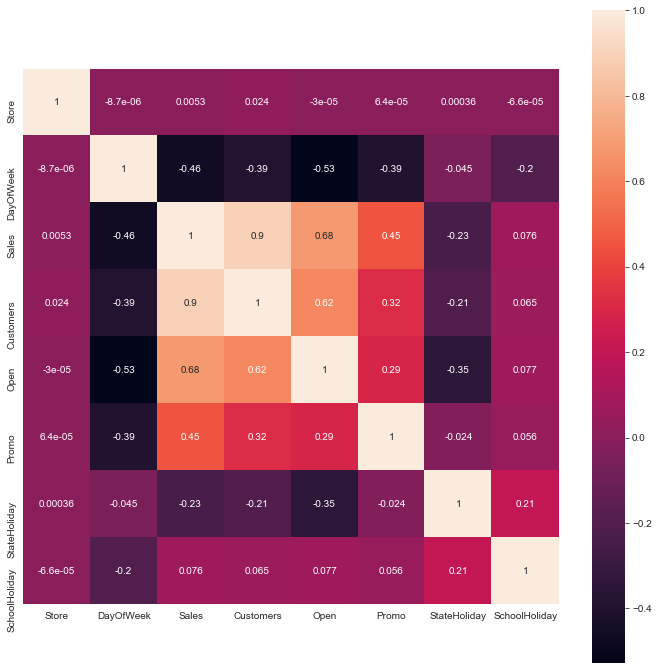

In [10]:
# check the correlation between variables
plt.figure(figsize=(12,12))
sns.heatmap(train_data.corr(),annot=True, square=True)

* The above heatmap shows that there is a very good correlation between 'sales' and 'customer'.
* 'Sales' is also related to 'Open' and 'promo'.
* 'Sales' is negatively correlated with 'StateHoliday' and 'DayOfWeek'

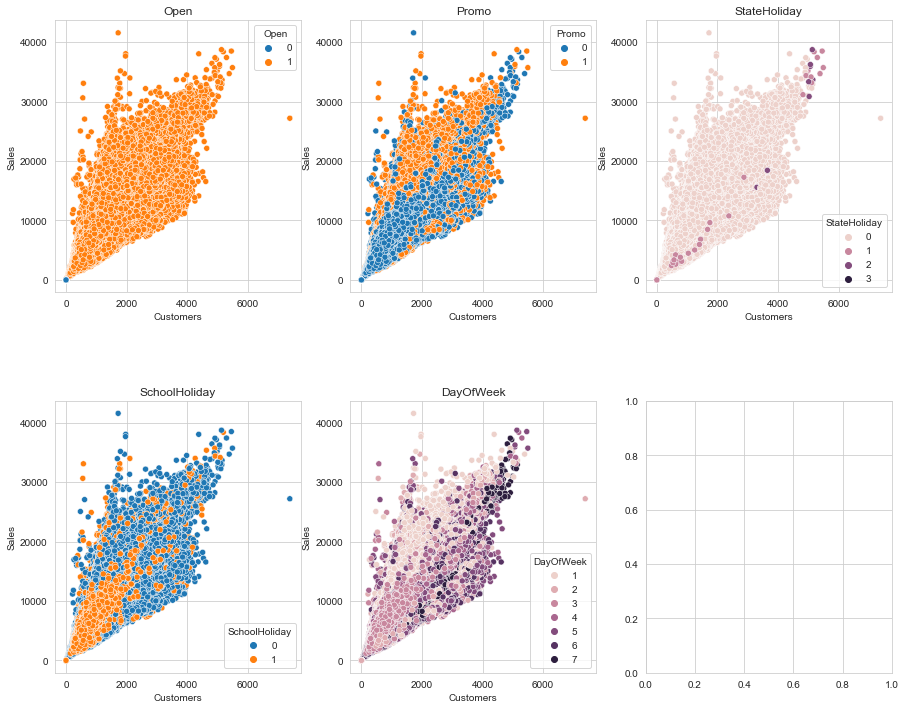

In [11]:
fig, axs = plt.subplots(2,3, figsize=(15,12))
fig.subplots_adjust(hspace=0.4)
axs=axs.ravel()
A_list = ['Open', 'Promo','StateHoliday', 'SchoolHoliday','DayOfWeek']
i=0
for col in A_list:
    sns.scatterplot(train_data.Customers,train_data.Sales,hue=train_data[col],ax=axs[i])
    axs[i].set_title(col)
    i+=1
        
fig.show()

From the above EDA analysis we can conclude as follow:

    * Sales is zero when shop is closed.
    
    * Sales is high when promo codes and discount is available.
    
    * Sales is either very low or very high on State Holidays.
    
    * Sales is high when schools are open.

### 3.  Apply Linear Regression to predict the forecast and evaluate different accuracy metrices like RMSE (Root Mean Squared Error) and MAE(Mean Absolute Error) and determine which metric makes more sense. Can there be a better accuracy metric?

#### a) Train a single model for all stores, using storeId as a feature.

In [12]:
## build linear regression model for all stores

In [13]:
##Total number of stores
n_shops = train_data.Store.nunique()
n_shops

1115

In [14]:
original_data = train_data.copy()
train_data.drop('Date', axis=1, inplace=True)

In [15]:
y=np.array(train_data['Sales'])
x=np.array(train_data.drop('Sales',axis=1))

In [16]:
lr = LinearRegression(normalize=True)

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 100, test_size=0.3)

In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(687850, 7)
(294794, 7)
(687850,)
(294794,)


In [19]:
lr.fit(x_train,y_train)

LinearRegression(normalize=True)

In [20]:
y_pred = lr.predict(x_test)

In [21]:
def error_cal(y_true,y_pred):
    RMSE = math.sqrt(mean_squared_error(y_true,y_pred))
    MAE = mean_absolute_error(y_true,y_pred)
    return RMSE,MAE

In [22]:
all_store_lr = error_cal(y_test,y_pred)
all_store_lr

(1471.475458119501, 978.5123617111672)

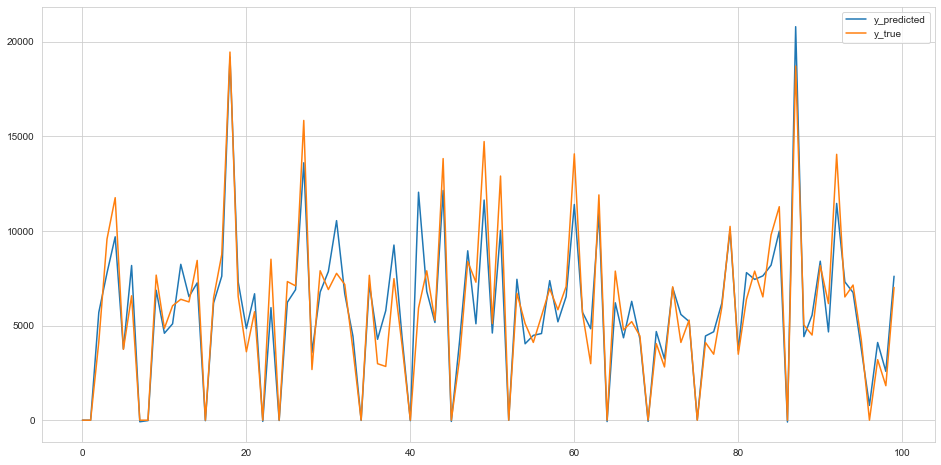

In [23]:
plt.figure(figsize=(16,8))
plt.plot(y_pred[:100],label = 'y_predicted')
plt.plot(y_test[:100], label = 'y_true')
plt.legend()
plt.show()

#### b) Train separate model for each store.

In [24]:
## build linear regression model for individual stores

In [25]:
def model_single_store(x,y):
    lr = LinearRegression(normalize=True)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    return y_test,y_pred

In [26]:
stores = [1,2,3,4,5,6,7,8,9,10,11]

In [27]:
RMSE_array_lr = []
MAE_array_lr=[]
for store in range(1,12):
    data = train_data[train_data.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = model_single_store(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_lr.append(RMSE_1)
    MAE_array_lr.append(MAE_1)

In [28]:
error_output_lr = pd.DataFrame()
error_output_lr['Stores'] = stores
error_output_lr['RMSE'] = RMSE_array_lr
error_output_lr['MAE'] = MAE_array_lr
error_output_lr

,Stores,RMSE,MAE
0,1,284.267843,208.057711
1,2,499.547398,300.639640
2,3,503.516363,380.807745
3,4,408.954683,293.918216
4,5,466.091596,342.290667
5,6,352.195690,257.880767
6,7,712.565579,536.974131
7,8,481.808989,345.948447
8,9,368.470541,261.323809
9,10,331.881675,259.922444


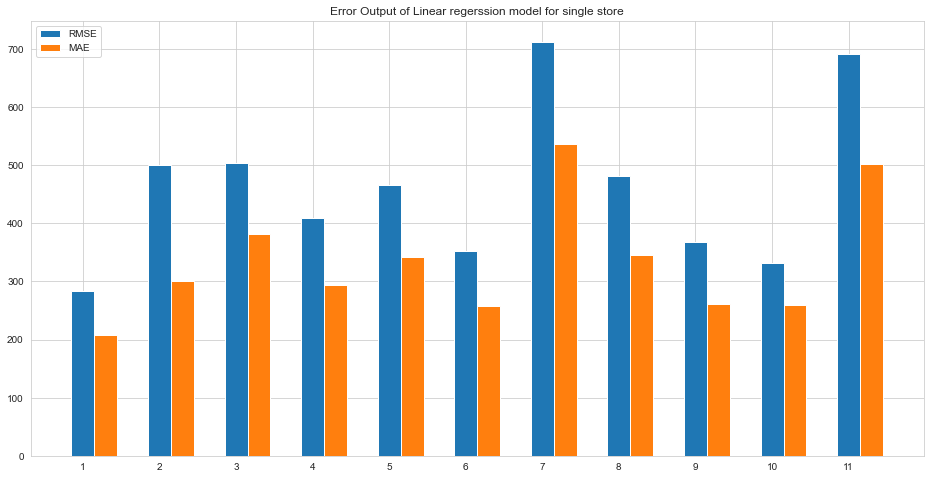

In [29]:
plt.figure(figsize=(16,8))
N = 12
x = np.arange(1,N)
plt.bar(x,height=error_output_lr.RMSE,label = 'RMSE',width = 0.3)
plt.bar(x+0.3,height=error_output_lr.MAE,label = 'MAE',width = 0.3)
plt.xticks(stores)
plt.legend()
plt.title('Error Output of Linear regerssion model for single store')
plt.show()

#### c) Which performs better and Why?

* Above model shows that accuracy increases when we train our model for individual store, because Sales might also depend on geographical or locality of the store, So when we predict for individual store then this factor could be treated as constant and can be neglected.

#### d) Try Ensemble of b) and c). What are the findings?

In [30]:
## ensemble learning

In [31]:
def adaboost_single_store(x,y):
    lr = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    return y_test,y_pred

In [32]:
RMSE_array_ada = []
MAE_array_ada =[]
for store in range(1,12):
    data = train_data[train_data.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = adaboost_single_store(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_ada.append(RMSE_1)
    MAE_array_ada.append(MAE_1)

In [33]:
error_output_ada = pd.DataFrame()
error_output_ada['Stores'] = stores
error_output_ada['RMSE'] = RMSE_array_ada
error_output_ada['MAE'] = MAE_array_ada
error_output_ada

,Stores,RMSE,MAE
0,1,359.790941,255.360556
1,2,448.281241,305.834994
2,3,540.741881,381.984390
3,4,478.518854,353.173600
4,5,358.276584,264.578576
5,6,405.072046,293.649487
6,7,762.623474,573.200371
7,8,462.982574,336.571569
8,9,431.440366,294.909974
9,10,340.029931,248.239667


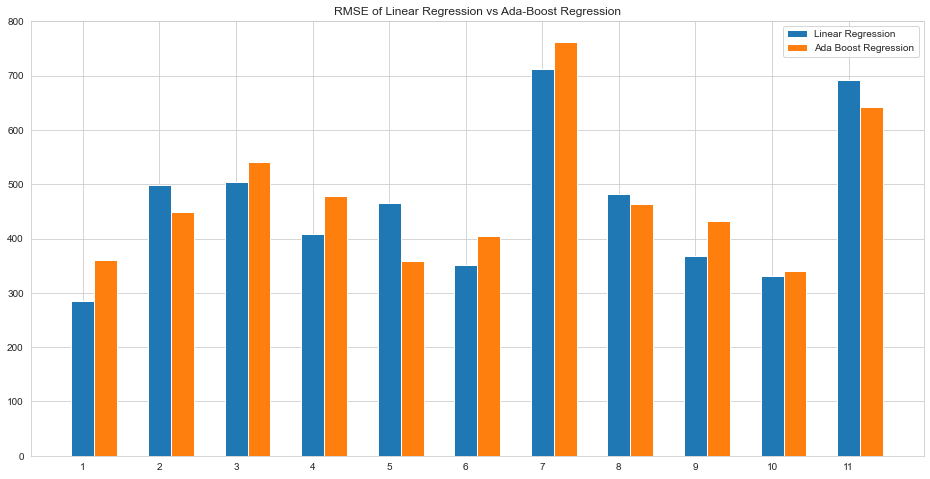

In [34]:
plt.figure(figsize=(16,8))
N=12
x=np.arange(1,N)
plt.bar(x,height=error_output_lr.RMSE,label = 'Linear Regression',width=0.3)
plt.bar(x+0.3,height=error_output_ada.RMSE,label = 'Ada Boost Regression',width=0.3)
plt.xticks(stores)
plt.legend()

plt.title('RMSE of Linear Regression vs Ada-Boost Regression')
plt.show()

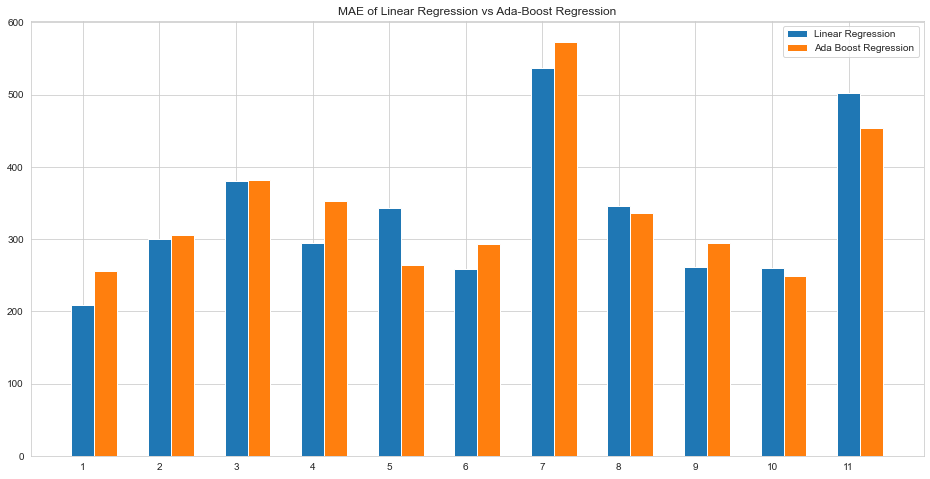

In [35]:
plt.figure(figsize=(16,8))
N=12
x=np.arange(1,N)
plt.bar(x,height=error_output_lr.MAE,label = 'Linear Regression',width=0.3)
plt.bar(x+0.3,height=error_output_ada.MAE,label = 'Ada Boost Regression',width=0.3)
plt.xticks(stores)
plt.legend()

plt.title('MAE of Linear Regression vs Ada-Boost Regression')
plt.show()

* By comparing RMSE and MAE of ada-boost regression and Linear regression, we can say that there is not much difference between these models.

#### e) Use Regularized Regression. It should perform better in an unseen test set. Any insights??

In [36]:
## regularised regression

In [37]:
def ridge_single_store(x,y):
    ridge = Ridge(alpha=0.00001,normalize=True)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=18)
    ridge.fit(x_train,y_train)
    y_pred = ridge.predict(x_test)
    return y_test,y_pred

In [38]:
RMSE_array_rdg = []
MAE_array_rdg =[]
for store in range(1,12):
    data = train_data[train_data.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = ridge_single_store(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_rdg.append(RMSE_1)
    MAE_array_rdg.append(MAE_1)

In [39]:
error_output_rdg = pd.DataFrame()
error_output_rdg['Stores'] = stores
error_output_rdg['RMSE'] = RMSE_array_rdg
error_output_rdg['MAE'] = MAE_array_rdg
error_output_rdg

,Stores,RMSE,MAE
0,1,253.651635,185.988246
1,2,658.876634,350.142560
2,3,505.016668,359.602319
3,4,440.340415,316.605281
4,5,482.497517,329.292617
5,6,318.540876,227.956072
6,7,717.864403,509.881475
7,8,472.085464,339.311060
8,9,403.765187,269.977126
9,10,335.135667,255.293371


#### f) Open-ended modeling to get possible predictions.

In [40]:
## Random forest regression model

In [41]:
def random_forest(x,y):
    rdm = RandomForestRegressor(n_estimators=60)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=36)
    rdm.fit(x_train,y_train)
    y_pred = rdm.predict(x_test)
    return y_test,y_pred

In [42]:
RMSE_array_rdm = []
MAE_array_rdm =[]
for store in range(1,12):
    data = train_data[train_data.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = random_forest(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_rdm.append(RMSE_1)
    MAE_array_rdm.append(MAE_1)

In [43]:
error_output_rdm = pd.DataFrame()
error_output_rdm['Stores'] = stores
error_output_rdm['RMSE'] = RMSE_array_rdm
error_output_rdm['MAE'] = MAE_array_rdm
error_output_rdm

,Stores,RMSE,MAE
0,1,293.766041,211.472855
1,2,381.014854,232.517338
2,3,442.631468,314.647135
3,4,456.553940,321.344239
4,5,323.012231,227.066429
5,6,318.773202,224.175162
6,7,697.971325,469.461827
7,8,383.821747,261.705540
8,9,338.337912,238.934426
9,10,329.585731,237.541445


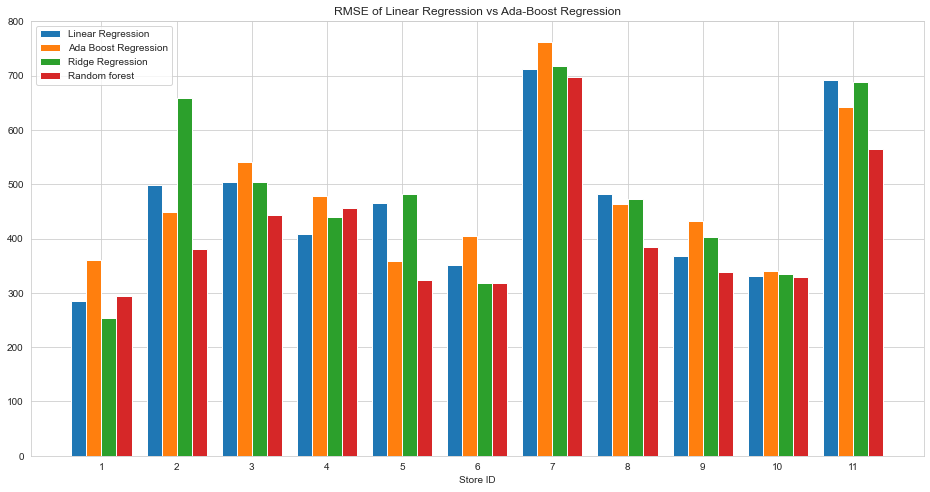

In [44]:
plt.figure(figsize=(16,8))
N=12
x=np.arange(1,N)
plt.bar(x,height=error_output_lr.RMSE,label = 'Linear Regression',width=0.2)
plt.bar(x+0.2,height=error_output_ada.RMSE,label = 'Ada Boost Regression',width=0.2)
plt.bar(x+0.4,height=error_output_rdg.RMSE,label = 'Ridge Regression',width=0.2)
plt.bar(x+0.6,height=error_output_rdm.RMSE,label = 'Random forest',width=0.2)
plt.xticks((2*x+0.6)/2,stores)
plt.xlabel('Store ID')
plt.legend()

plt.title('RMSE of Linear Regression vs Ada-Boost Regression')
plt.show()

* From the above graph we cannot justify that which model is best. so calculate average error.

In [45]:
# print('Average RMSE Linear regression Error: {}'.format(error_output_lr.RMSE.mean()))
print('Average RMSE Ada-boost regression Error: {}'.format(error_output_ada.RMSE.mean()))
print('Average RMSE Ridge regression Error: {}'.format(error_output_rdg.RMSE.mean()))
print('Average RMSE Random Forest regression Error: {}'.format(error_output_rdm.RMSE.mean()))

Average RMSE Ada-boost regression Error: 475.39461525677564
Average RMSE Ridge regression Error: 479.6911645282402
Average RMSE Random Forest regression Error: 411.82760368071763


* From Here we can conclude that upto this point random forest performs best.

## Project Task: Week 2

### Other Regression Techniques:

#### 1. When store is closed, sales = 0. Can this insight be used for Data Cleaning? Perform this and retrain the model. Any benefits of this step?

* When store is closed then there will be no sale. Hence remove that rows.

In [46]:
open_store_data = train_data[train_data.Open == 1]
open_store_data.drop('Open',axis=1,inplace=True)
open_store_data.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,2,5735,568,1,0,0
1,2,2,9863,877,1,0,0
2,3,2,13261,1072,1,0,1
3,4,2,13106,1488,1,0,0
4,5,2,6635,645,1,0,0


In [47]:
RMSE_array_lrc = []
MAE_array_lrc=[]
for store in range(1,12):
    data = open_store_data[open_store_data.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = model_single_store(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_lrc.append(RMSE_1)
    MAE_array_lrc.append(MAE_1)

In [48]:
error_output_lrc = pd.DataFrame()
error_output_lrc['Stores'] = stores
error_output_lrc['RMSE'] = RMSE_array_lrc
error_output_lrc['MAE'] = MAE_array_lrc
error_output_lrc

,Stores,RMSE,MAE
0,1,271.285014,216.794418
1,2,557.155161,364.294090
2,3,649.968842,476.379140
3,4,444.729628,346.986200
4,5,534.652008,409.715061
5,6,361.446231,269.610691
6,7,770.399228,572.891939
7,8,458.349199,371.704818
8,9,391.073084,309.433183
9,10,347.720527,290.885499


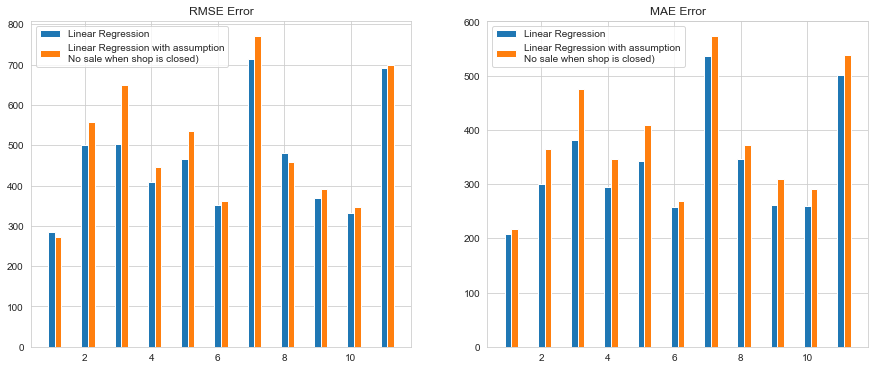

In [49]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.subplots_adjust(hspace=0.4)
axs=axs.ravel()
N=12
x=np.arange(1,N)
i=0
for col in ['RMSE','MAE']:
    axs[i].bar(x,height=error_output_lr[col],label = 'Linear Regression',width=0.2)
    axs[i].bar(x+0.2,height=error_output_lrc[col],label = 'Linear Regression with assumption\nNo sale when shop is closed)',width=0.2)
    axs[i].legend()
    axs[i].set_title(col+' Error')
    i+=1

* The above graph shoes that both types of error get increased when we removed the rows when store are closed.
* I think the main reason for this increased error rate is that, our previous model was predicting accurately when store was closed, so while taking mean of that portion the error output got reduced, but in updated model as we removed that rows, so while taking mean it get increased error output.
* So we do not get any benefit of removing those rows.

#### 2. Use Non-Linear Regressors like Random Forest or other Tree-based Regressors.

#### a) Train a single model for all stores, where storeId can be a feature.

In [50]:
## random forest model for updated cleaned data

In [51]:
open_store_data.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,2,5735,568,1,0,0
1,2,2,9863,877,1,0,0
2,3,2,13261,1072,1,0,1
3,4,2,13106,1488,1,0,0
4,5,2,6635,645,1,0,0


In [52]:
y=np.array(data['Sales'])
x=np.array(data.drop('Sales',axis=1))
y_true,y_pred = random_forest(x,y)

In [53]:
RMSE_rdm,MAE_rdm = error_cal(y_true,y_pred)

In [54]:
print('Root mean squared error: ',RMSE_rdm)
print('Mean absolute error: ',MAE_rdm)

Root mean squared error:  734.5806667844583
Mean absolute error:  498.21204030910604


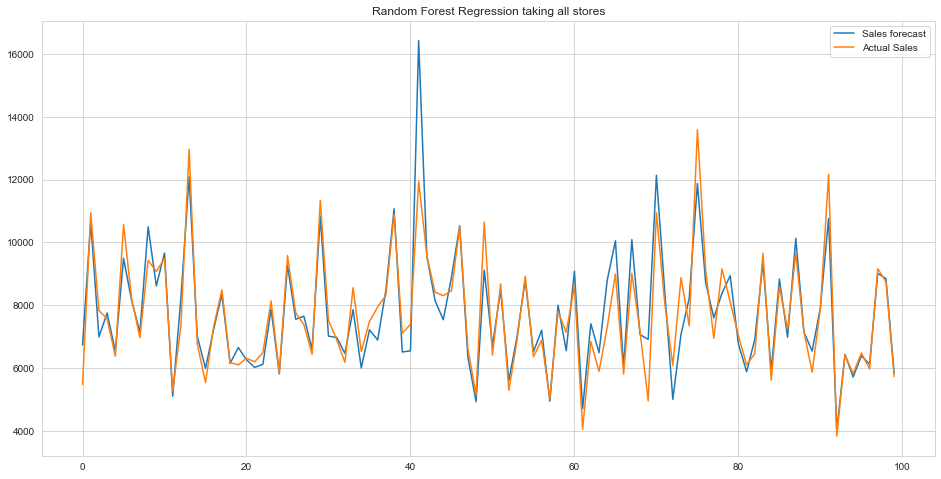

In [55]:
plt.figure(figsize=(16,8))
plt.plot(y_pred[:100],label = 'Sales forecast')
plt.plot(y_true[:100],label = 'Actual Sales')
plt.legend()
plt.title('Random Forest Regression taking all stores')
plt.show()

#### b) Train separate models for each store.

#### Note:
Dimensional Reduction techniques like, PCA and Tree’s Hyperparameter Tuning will be required. Cross-validate to find the best parameters. Infer the performance of both the models.

In [56]:
open_store_data.reset_index(drop=True,inplace=True)

In [57]:
x = open_store_data.drop(['Sales','Store'],axis=1)
x = StandardScaler().fit_transform(x)

In [58]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

In [59]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC_1', 'pc_2','PC_3'])

In [60]:
finaldf = pd.concat([open_store_data[['Store','Sales']],principalDf],axis=1)

In [61]:
finaldf.head()

,Store,Sales,PC_1,pc_2,PC_3
0,1,5735,0.891968,-0.602281,0.120771
1,2,9863,1.221942,-0.516040,0.489858
2,3,13261,2.075741,0.506591,-1.261974
3,4,13106,1.874415,-0.345512,1.219671
4,5,6635,0.974194,-0.580790,0.212744


In [62]:
finaldf.reset_index(drop=True,inplace=True)

In [63]:
## k-fold

In [64]:
def get_stats(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    RMSE,MAE = error_cal(y_test,y_pred)
    return [RMSE,MAE]

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()

In [66]:
y = np.array(finaldf['Sales'])
x = np.array(finaldf.drop('Sales',axis=1))

In [67]:
score_rdm = []
score_dt = []
kf = StratifiedKFold(n_splits=5,random_state=100)
for train_index,test_index in kf.split(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=53)
    score_dt.append(get_stats(DecisionTreeRegressor(),x_train,y_train,x_test,y_test))
    score_rdm.append(get_stats(RandomForestRegressor(n_estimators=10),x_train,y_train,x_test,y_test))

In [68]:
k_fold_df = pd.DataFrame()
k_fold_df['decision_tree']=pd.DataFrame(score_dt,columns=['RMSE','MAE']).mean(axis=0)
k_fold_df['Random_forest']=pd.DataFrame(score_rdm,columns=['RMSE','MAE']).mean(axis=0)

In [69]:
k_fold_df

,decision_tree,Random_forest
RMSE,1111.161370,934.724327
MAE,667.705973,604.585739


In [70]:
## for individual stores

In [71]:
## random forest model
RMSE_array_rdm_pca = []
MAE_array_rdm_pca = []
for store in range(1,12):
    data = finaldf[finaldf.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = random_forest(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_rdm_pca.append(RMSE_1)
    MAE_array_rdm_pca.append(MAE_1)

In [72]:
error_output_rdm_pca = pd.DataFrame()
error_output_rdm_pca['Stores'] = stores
error_output_rdm_pca['RMSE'] = RMSE_array_rdm_pca
error_output_rdm_pca['MAE'] = MAE_array_rdm_pca
error_output_rdm_pca

,Stores,RMSE,MAE
0,1,359.741644,274.435304
1,2,473.322539,305.738169
2,3,506.315693,376.542205
3,4,682.783634,505.468094
4,5,531.106836,339.087485
5,6,484.833955,342.828062
6,7,833.074592,613.688458
7,8,428.007893,310.298831
8,9,505.587707,375.327604
9,10,389.369208,305.832056


In [73]:
def decision_tree(x,y):
    dt = DecisionTreeRegressor()
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=36)
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    return y_test,y_pred

In [74]:
## decision tree model
RMSE_array_dt_pca = []
MAE_array_dt_pca = []
for store in range(1,12):
    data = finaldf[finaldf.Store==store]
    data.drop('Store',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_true,y_pred = decision_tree(x,y)
    RMSE_1,MAE_1 = error_cal(y_true,y_pred)
    RMSE_array_dt_pca.append(RMSE_1)
    MAE_array_dt_pca.append(MAE_1)

In [75]:
error_output_dt_pca = pd.DataFrame()
error_output_dt_pca['Stores'] = stores
error_output_dt_pca['RMSE'] = RMSE_array_dt_pca
error_output_dt_pca['MAE'] = MAE_array_dt_pca
error_output_dt_pca

,Stores,RMSE,MAE
0,1,429.814710,318.719577
1,2,539.282636,347.978070
2,3,623.503335,450.341312
3,4,798.853400,566.110526
4,5,522.576826,382.338652
5,6,645.673189,429.274250
6,7,1020.463707,747.373684
7,8,474.543395,353.057895
8,9,578.754419,430.102837
9,10,445.050558,358.442982


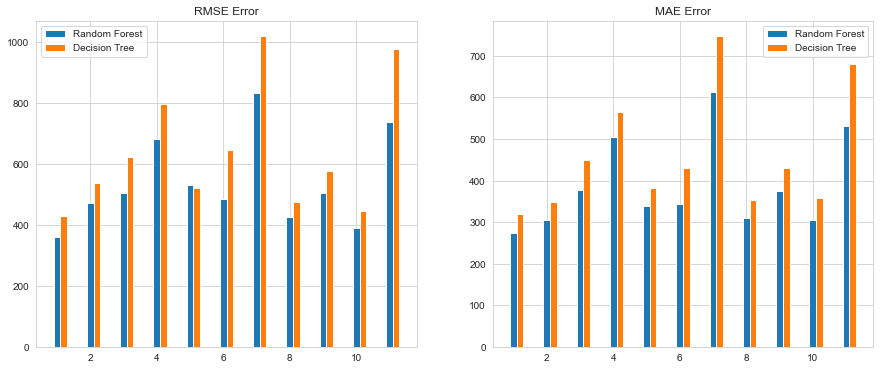

In [76]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.subplots_adjust(hspace=0.4)
axs=axs.ravel()
N=12
x=np.arange(1,N)
i=0
for col in ['RMSE','MAE']:
    axs[i].bar(x,height=error_output_rdm_pca[col],label = 'Random Forest',width=0.2)
    axs[i].bar(x+0.2,height=error_output_dt_pca[col],label = 'Decision Tree',width=0.2)
    axs[i].legend()
    axs[i].set_title(col+' Error')
    i+=1

In [77]:
print('Average RMSE Decision Tree Error: {}'.format(error_output_dt_pca.RMSE.mean()))
print('Average RMSE Random Forest Error: {}'.format(error_output_rdm_pca.RMSE.mean()))

Average RMSE Decision Tree Error: 641.4061551719874
Average RMSE Random Forest Error: 539.3957964010076


#### 3. Compare the performance of Linear Model and Non-Linear Model from the previous observations. Which performs better and why?

In [78]:
## compare the performance of linear and non linear model

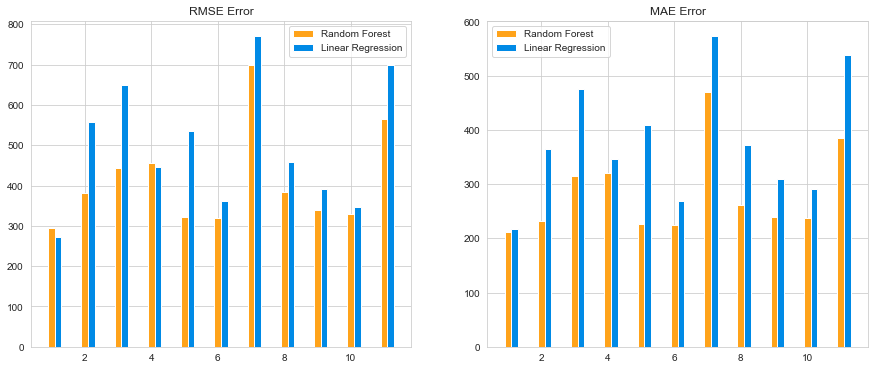

In [83]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.subplots_adjust(hspace=0.4)
axs=axs.ravel()
N=12
x=np.arange(1,N)
i=0
for col in ['RMSE','MAE']:
    axs[i].bar(x,height=error_output_rdm[col],label = 'Random Forest',width=0.2,color = '#ffa31a')
    axs[i].bar(x+0.2,height=error_output_lrc[col],label = 'Linear Regression',width=0.2,color = '#008ae6')
    axs[i].legend()
    axs[i].set_title(col+' Error')
    i+=1

In [84]:
print('Average RMSE Random Forest Error: {}'.format(error_output_rdm.RMSE.mean()))
print('Average RMSE Linear Regression Error: {}'.format(error_output_lrc.RMSE.mean()))

Average RMSE Random Forest Error: 411.82760368071763
Average RMSE Linear Regression Error: 498.6368743223171


* From the above graph, it is clear that non-linear model i.e. random forest performs better than Linear Regression model.
* So we can say that our dataset is not liearly separable.

#### 4. Train a Time-series model on the data taking time as the only feature. This will be a store-level training.

#### a) Identify yearly trends and seasonal months

In [85]:
## Time series analysis

In [86]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52,center = False).mean()
    rolstd = timeseries.rolling(window = 52,center = False).std()
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries,color = '#3399ff',label = 'Original')
    mean = plt.plot(rolmean,color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd,color = 'green',label = 'Rolling Std')
    plt.title('Rolling mean and Standard deviation')
    plt.legend(loc='best')
    plt.show(block=False)
    
    print('Result of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','Number of lag used','Number of observation used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [87]:
original_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2015-06-30,5735,568,1,1,0,0
1,2,2,2015-06-30,9863,877,1,1,0,0
2,3,2,2015-06-30,13261,1072,1,1,0,1
3,4,2,2015-06-30,13106,1488,1,1,0,0
4,5,2,2015-06-30,6635,645,1,1,0,0


In [88]:
original_data.sort_values('Date',inplace=True)

In [89]:
original_data = original_data[original_data.Open==1]
original_data.reset_index(drop = True,inplace=True)


In [90]:
## lets see the sales graph as per time.

In [91]:
datax = original_data[original_data.Store==1][['Date','Sales']]
datax.set_index('Date',inplace=True)

In [92]:
datax

,Sales
Date,
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
2013-01-07,7176
...,...
2015-06-25,3533
2015-06-26,3317
2015-06-27,4019


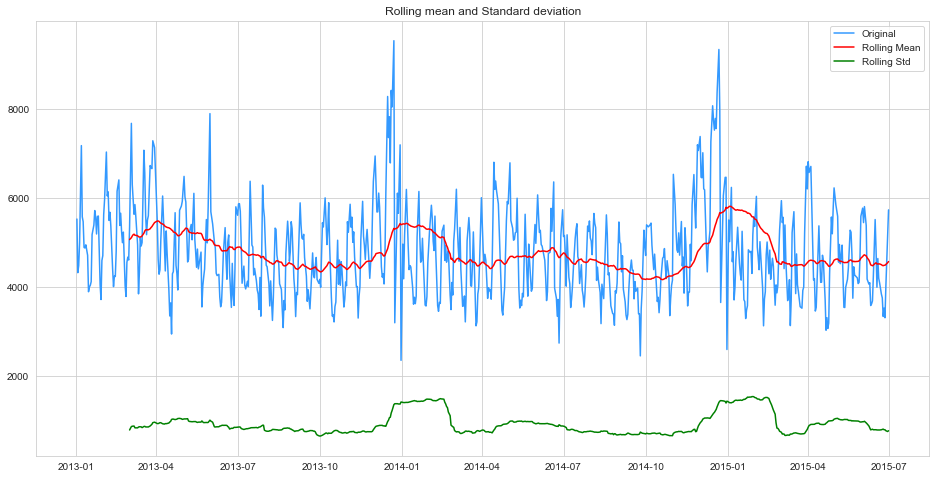

Result of Dickey-Fuller Test: 
Test Statistic                 -5.336702
p-value                         0.000005
Number of lag used             13.000000
Number of observation used    740.000000
Critical Value (1%)            -3.439218
Critical Value (5%)            -2.865454
Critical Value (10%)           -2.568854
dtype: float64


In [93]:
test_stationarity(datax)

* p-value is very close to zero so we will reject the null hypothesis, that data does not have a unit root and is stationary.
* However, data shows some seasonal effects.

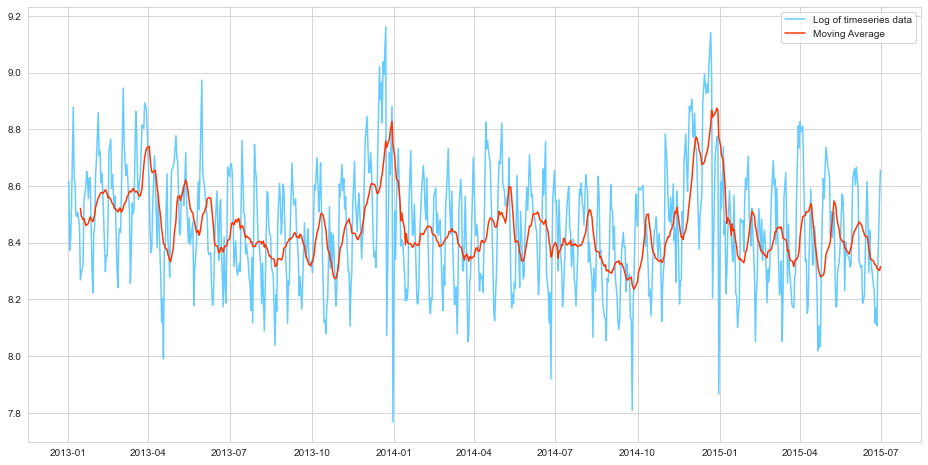

In [94]:
ts_log = np.log(datax)
movingavg = ts_log.rolling(window = 12).mean()
plt.figure(figsize=(16,8))
plt.plot(ts_log,color='#66ccff',label = 'Log of timeseries data')
plt.plot(movingavg,color='#ff3300',label = 'Moving Average')
plt.legend()
plt.show()

* From the above graph we can see seasonal effect in the dataset.
* In dec to jan month sale is high in comaprison to other month

In [95]:
## time series model

In [96]:
ts_log_mv_diff = ts_log - movingavg
ts_log_mv_diff.dropna(inplace=True)

* Since p-value is less than 0.05, so we can say that data is stationary.
* hence differencing is not required, therefore d = 0.

<Figure size 1152x576 with 0 Axes>

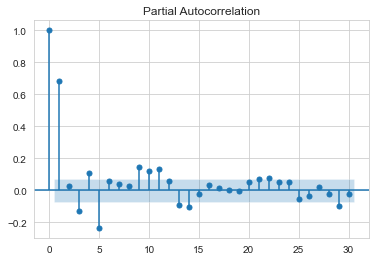

In [97]:
plt.figure(figsize=(16,8))
plot_pacf(datax.dropna(), lags=30)
plt.show()

* The first lag is the only one vastly above the signicance level and so p = 1.

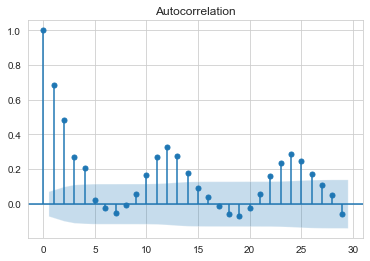

In [98]:
plot_acf(datax.dropna())
plt.show()

* Four lag can be found above the significance level and thus q = 4.

In [99]:
model = ARIMA(np.array(datax[:-6]), order=(1, 0, 4))
results = model.fit()

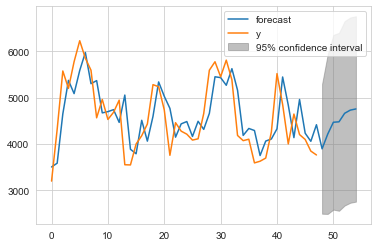

In [162]:
results.plot_predict(700,754)
plt.show()

In [101]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  748
Model:                     ARMA(1, 4)   Log Likelihood               -5977.693
Method:                       css-mle   S.D. of innovations            714.770
Date:                Sat, 17 Oct 2020   AIC                          11969.386
Time:                        17:55:22   BIC                          12001.707
Sample:                             0   HQIC                         11981.841
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4771.0302     81.286     58.694      0.000    4611.713    4930.348
ar.L1.y        0.3738      0.127      2.949      0.003       0.125       0.622
ma.L1.y        0.3420      0.127      2.689      0.007       0.093       0.591
ma.L2.y        0.2795      0.092      3.030      0.002       0.099       0.460
ma.L3.y        0.0544      0.062      0.878      0.380      -0.067       0.176
ma.L4.y        0.2763      0.035      8.002      0.000       0.209       0.344
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6754           +0.0000j            2.6754            0.0000
MA.1           -0.8914           -0.9326j            1.2901           -0.3714
MA.2           -0.8914           +0.9326j            1.2901            0.3714
MA.3            0.7930           -1.2434j            1.4748           -0.1596
MA.4            0.7930           +1.2434j            1.4748            0.1596
-----------------------------------------------------------------------------
"""

In [102]:
RMSE_ARIMA = math.sqrt(mean_squared_error(np.array(datax[700:]) , results.predict(700,753)))
RMSE_ARIMA

587.1520321281363

In [103]:
MAE_ARIMA = mean_absolute_error(np.array(datax[700:]) , results.predict(700,753))
MAE_ARIMA

482.5240578776619

* Similarly we can predict for other stores

## Project Task: Week 3

### Implementing Neural Networks:

#### 1. Train a LSTM on the same set of features and compare the result with traditional time-series model.

In [104]:
std = datax.std()
mean = datax.mean()
timeseries = np.array((datax-mean)/std)

In [105]:
training_size = int(len(timeseries)*0.65)
test_size = len(timeseries)-training_size
train_size,test_size = timeseries[:training_size,:],timeseries[training_size:len(timeseries),:1]

In [106]:
def create_dataset(dataset,time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [107]:
time_step =100
x_train,y_train = create_dataset(train_size,time_step)
x_test,y_test = create_dataset(test_size,time_step)

In [108]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [109]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [111]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('Sales.h5',
                            monitor='loss',
                            mode=min,
                            save_best_only=True,
                            verbose=1)

early_stopping = EarlyStopping(monitor='loss',
                              patience=9,
                              min_delta=0,
                              restore_best_weights=True,
                              verbose=1)

Reduce_ler_rate = ReduceLROnPlateau(monitor='loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=1,
                                   min_delta=0.001)

callback = [checkpoint,early_stopping,Reduce_ler_rate]

In [112]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200,batch_size=64,verbose=1,callbacks=callback)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 0.8899
Epoch 00001: loss improved from inf to 0.88987, saving model to Sales.h5
7/7 [==============================] - 2s 265ms/step - loss: 0.8899 - val_loss: 1.1912
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 0.8719
Epoch 00002: loss improved from 0.88987 to 0.87194, saving model to Sales.h5
7/7 [==============================] - 1s 110ms/step - loss: 0.8719 - val_loss: 1.2051
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 0.8729
Epoch 00003: loss did not improve from 0.87194
7/7 [==============================] - 1s 86ms/step - loss: 0.8729 - val_loss: 1.2066
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 0.8680
Epoch 00004: loss improved from 0.87194 to 0.86797, saving model to Sales.h5
7/7 [==============================] - 1s 113ms/step - loss: 0.8680 - val_loss: 1.1481
Epoch 5/200
7/7 [==============================] - ETA: 0s - loss: 0.8658
Epoch 000

Epoch 36/200
7/7 [==============================] - ETA: 0s - loss: 0.7048
Epoch 00036: loss improved from 0.70879 to 0.70479, saving model to Sales.h5
7/7 [==============================] - 1s 109ms/step - loss: 0.7048 - val_loss: 0.8288
Epoch 37/200
7/7 [==============================] - ETA: 0s - loss: 0.7008
Epoch 00037: loss improved from 0.70479 to 0.70083, saving model to Sales.h5
7/7 [==============================] - 1s 143ms/step - loss: 0.7008 - val_loss: 0.8513
Epoch 38/200
7/7 [==============================] - ETA: 0s - loss: 0.6965
Epoch 00038: loss improved from 0.70083 to 0.69650, saving model to Sales.h5
7/7 [==============================] - 1s 138ms/step - loss: 0.6965 - val_loss: 0.8539
Epoch 39/200
7/7 [==============================] - ETA: 0s - loss: 0.6965
Epoch 00039: loss improved from 0.69650 to 0.69650, saving model to Sales.h5
7/7 [==============================] - 1s 127ms/step - loss: 0.6965 - val_loss: 0.8364
Epoch 40/200
7/7 [==========================

Epoch 106/200
7/7 [==============================] - ETA: 0s - loss: 0.5535
Epoch 00106: loss improved from 0.55383 to 0.55349, saving model to Sales.h5
7/7 [==============================] - 1s 107ms/step - loss: 0.5535 - val_loss: 1.0359
Epoch 107/200
7/7 [==============================] - ETA: 0s - loss: 0.5531
Epoch 00107: loss improved from 0.55349 to 0.55310, saving model to Sales.h5
7/7 [==============================] - 1s 169ms/step - loss: 0.5531 - val_loss: 1.0347
Epoch 108/200
7/7 [==============================] - ETA: 0s - loss: 0.5530
Epoch 00108: loss improved from 0.55310 to 0.55299, saving model to Sales.h5

Epoch 00108: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
7/7 [==============================] - 1s 112ms/step - loss: 0.5530 - val_loss: 1.0337
Epoch 109/200
7/7 [==============================] - ETA: 0s - loss: 0.5526
Epoch 00109: loss improved from 0.55299 to 0.55258, saving model to Sales.h5
7/7 [==============================] - 1s 114

In [113]:
model = load_model('sales.h5')

In [114]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [115]:
#train_predict = std.inverse_transform(train_predict)
train_predict = train_predict.reshape(len(train_predict))
#test_predict = std.inverse_transform(test_predict)
test_predict = test_predict.reshape(len(test_predict))

In [116]:
# inversion of normalisation
train_predict = train_predict*std.values + mean.values
test_predict = test_predict*std.values + mean.values
y_train = y_train*std.values + mean.values
y_test = y_test*std.values + mean.values

In [117]:
RMSE_LSTM = math.sqrt(mean_squared_error(y_train,train_predict))
RMSE_LSTM

758.7049250457853

In [118]:
RMSE_LSTM = math.sqrt(mean_squared_error(y_test,test_predict))
RMSE_LSTM

1038.4188839819349

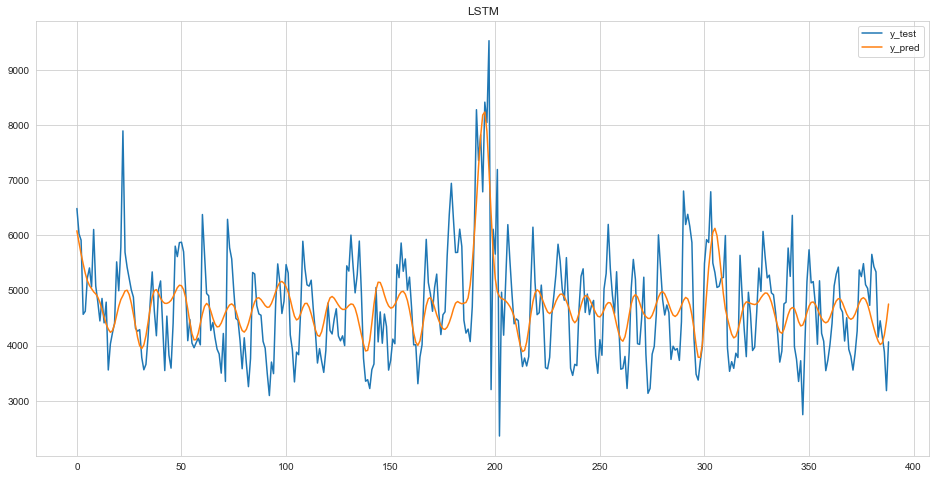

In [119]:
plt.figure(figsize = (16,8))
plt.plot(y_train, label = 'y_test')
plt.plot(train_predict,label = 'y_pred')
plt.title('LSTM')
plt.legend()
plt.show()

* Here, Tradional Time-Series models performs better than LSTM model.

#### 2. Comment on the behavior of all the models you have built so far

In [121]:
models_error = [[error_output_lr.RMSE.mean(), 'linear regression model']] # linear regression model
models_error.append([error_output_ada.RMSE.mean(),'Ada-Boost Regression']) # Ada-Boost Regression
models_error.append([error_output_rdg.RMSE.mean(),'Ridge Regression']) # Ridge Regression
models_error.append([error_output_rdm.RMSE.mean(),'Random Forest Regression']) # Random Forest Regression
models_error.append([error_output_lrc.RMSE.mean(),'Linear Regression when store is open']) # Linear Regression when store is open
models_error.append([error_output_dt_pca.RMSE.mean(),'Decision Tree with PCA'])
models_error.append([error_output_rdm_pca.RMSE.mean(),'Random Forest with PCA'])
models_error.append([RMSE_ARIMA,'ARIMA model for a Store'])
models_error.append([RMSE_LSTM, 'LSTM model for a Store'])

In [122]:
models_error = pd.DataFrame(models_error)

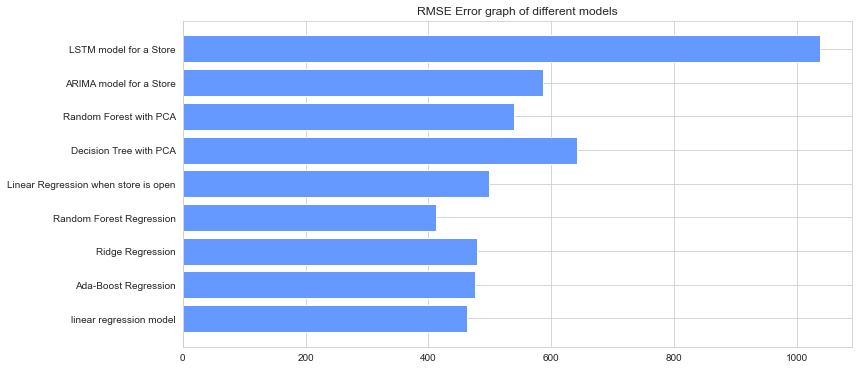

In [123]:
plt.figure(figsize=(12,6))
plt.barh(models_error[1],models_error[0], color = "#6699ff")
plt.title('RMSE Error graph of different models')
plt.show()

* From the above graph we can clearly says that Random forest performs best out of all models.

#### 3. Cluster stores using sales and customer visits as features. Find out how many clusters or groups are possible. Also visualize the results.

In [124]:
cluster_data = train_data[train_data.Open==1]
cluster_data = cluster_data[['Store','Sales','Customers']]
cluster_data.head()

,Store,Sales,Customers
0,1,5735,568
1,2,9863,877
2,3,13261,1072
3,4,13106,1488
4,5,6635,645


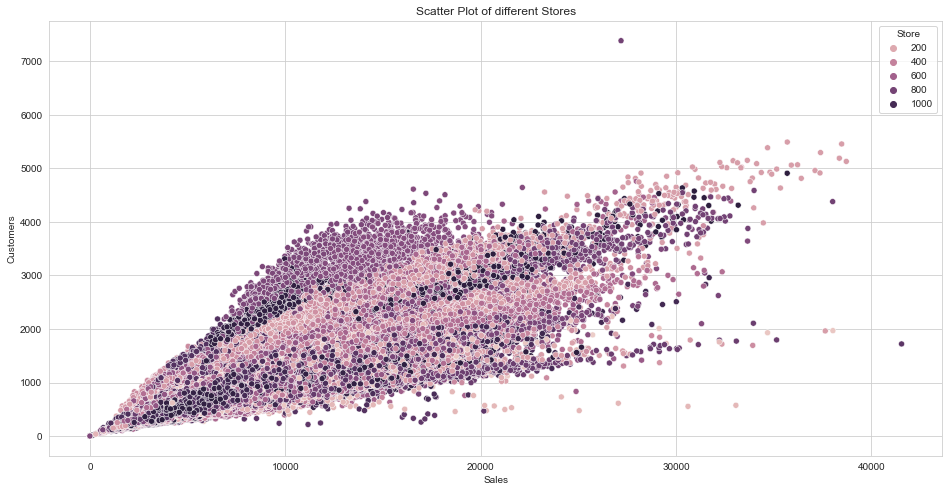

In [125]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=cluster_data,x='Sales',y='Customers', hue = 'Store')
plt.title('Scatter Plot of different Stores')
plt.show()

In [126]:
kmeans = KMeans(n_clusters=5, random_state=24).fit(np.array(cluster_data[['Sales','Customers']]))

In [127]:
cluster_data['forecast'] = kmeans.predict(np.array(cluster_data[['Sales','Customers']]))

In [128]:
cluster_data.head()

,Store,Sales,Customers,forecast
0,1,5735,568,4
1,2,9863,877,2
2,3,13261,1072,0
3,4,13106,1488,0
4,5,6635,645,4


In [129]:
kmeans.labels_

array([4, 2, 0, ..., 4, 1, 4])

In [130]:
kmeans.cluster_centers_

array([[11803.70771128,  1251.32555353],
       [ 3916.63178054,   464.9306038 ],
       [ 8474.27675303,   891.97780749],
       [18132.02765881,  2136.40709015],
       [ 6093.47766668,   672.3953813 ]])

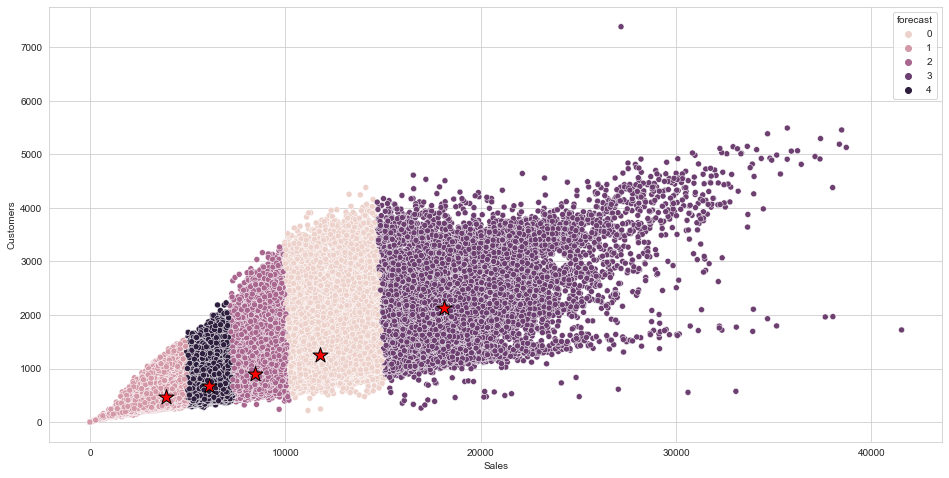

In [131]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=cluster_data,x='Sales',y='Customers', hue = 'forecast')
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.show()

#### 4. Is it possible to have separate prediction models for each cluster? Compare results with the previous models.

* We will choose Random Forest Regression and prepare a separate prediction model for each cluster.

In [132]:
cluster_data = train_data[train_data.Open == 1]
cluster_data.drop('Open',axis=1,inplace=True)

In [133]:
kmeans = KMeans(n_clusters=5, random_state=24).fit(np.array(cluster_data[['Sales','Customers']]))
cluster_data['forecast'] = kmeans.predict(np.array(cluster_data[['Sales','Customers']]))

In [134]:
cluster_data.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,forecast
0,1,2,5735,568,1,0,0,4
1,2,2,9863,877,1,0,0,2
2,3,2,13261,1072,1,0,1,0
3,4,2,13106,1488,1,0,0,0
4,5,2,6635,645,1,0,0,4


In [135]:
cluster_data.drop('Store',axis=1,inplace=True)

In [136]:
RMSE_cluster_rdm = []
MAE_cluster_rdm=[]
for clust in range(5):
    data = cluster_data[cluster_data.forecast==clust]
    data.drop('forecast',axis=1,inplace=True)
    y=np.array(data['Sales'])
    x=np.array(data.drop('Sales',axis=1))
    y_test,y_pred  = random_forest(np.array(x),np.array(y))
    RMSE_1,MAE_1 = error_cal(y_test,y_pred)
    RMSE_cluster_rdm.append(RMSE_1)
    MAE_cluster_rdm.append(MAE_1)

In [137]:
cluster = [0,1,2,3,4]

In [138]:
error_output_cluster_rdm = pd.DataFrame()
error_output_cluster_rdm['cluster'] = cluster
error_output_cluster_rdm['RMSE'] = RMSE_cluster_rdm
error_output_cluster_rdm['MAE'] = MAE_cluster_rdm
error_output_cluster_rdm

,cluster,RMSE,MAE
0,0,1222.541431,971.439099
1,1,543.165394,433.964896
2,2,770.898979,636.430048
3,3,2522.615663,1831.995396
4,4,596.155043,494.302385


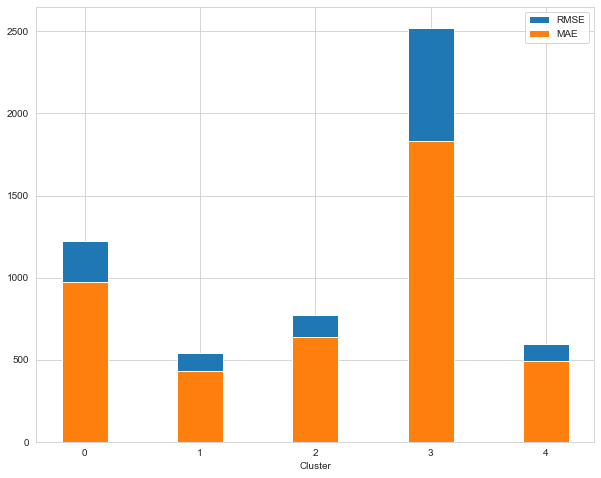

In [139]:
plt.figure(figsize=(10,8))
plt.bar(x=error_output_cluster_rdm.cluster,height=error_output_cluster_rdm.RMSE,label = 'RMSE',width=0.4)
plt.bar(x=error_output_cluster_rdm.cluster,height=error_output_cluster_rdm.MAE,label = 'MAE',width=0.4)
plt.xlabel('Cluster')
plt.legend()
plt.show()

* since data is not suitable for clustring, we can not separate data into different clusters.
* so while predicting sales based on clusters, it shows unpredictible result (RMSE, and MAE)

## Project Task: Week 4

### Applying ANN:

#### 1. Use ANN (Artificial Neural Network) to predict Store Sales.

       a)    Fine-tune number of layers,
       
       b)    Number of Neurons in each layers.
       
       c)    Experiment in batch-size.
       
       d)    Experiment with number of epochs. Carefully observe the loss and accuracy? What are the observations?
       
       e)    Play with different  Learning Rate  variants of Gradient Descent like Adam, SGD, RMS-prop.
       
       f)    Which activation performs best for this use case and why?
       
       g)    Check how it performed in the dataset, calculate RMSE.
       

* I have tested so many combinations of hyper-parameters and finally i found best result as follow: -

In [140]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,5735,568,1,1,0,0
1,2,2,9863,877,1,1,0,0
2,3,2,13261,1072,1,1,0,1
3,4,2,13106,1488,1,1,0,0
4,5,2,6635,645,1,1,0,0


In [141]:
train_data = train_data[train_data.Store<=100]
train_data = train_data[train_data.Open == 1]
train_data.reset_index(drop=True, inplace=True)

y = train_data['Sales']
x = train_data.drop(['Sales','Open'],axis=1)

std = StandardScaler()
x = std.fit_transform(x)

In [142]:
x_train,x_test,y_train,y_test = train_test_split(np.array(x),np.array(y),random_state=42,test_size=0.3)

In [143]:
model_1 = Sequential()
model_1.add(layers.Dense(32, activation='elu', input_shape = (x_train.shape[1],)))
model_1.add(layers.Dense(64, activation='elu'))
model_1.add(layers.Dense(64, activation='elu'))
model_1.add(layers.BatchNormalization())

## block 2
model_1.add(layers.Dense(128, activation='elu'))
model_1.add(layers.Dense(128, activation='elu'))
model_1.add(layers.BatchNormalization())

## block 3
model_1.add(layers.Dense(256, activation='elu'))
model_1.add(layers.Dense(256, activation='elu'))
model_1.add(layers.BatchNormalization())

## block 4
model_1.add(layers.Dense(128, activation='elu'))
model_1.add(layers.Dense(128, activation='elu'))
model_1.add(layers.BatchNormalization())

## block 5
model_1.add(layers.Dense(64, activation='elu'))
model_1.add(layers.Dense(64, activation='elu'))
model_1.add(layers.Dense(32, activation='elu'))
model_1.add(layers.Dense(1))

In [144]:
model_1.compile(loss='mse',
              optimizer = Adam(learning_rate=0.001),
              metrics=['mae'])

In [145]:
checkpoint = ModelCheckpoint('Sales_ann.h5',
                            monitor='loss',
                            mode=min,
                            save_best_only=True,
                            verbose=1)

early_stopping = EarlyStopping(monitor='loss',
                              patience=9,
                              min_delta=0,
                              restore_best_weights=True,
                              verbose=1)

Reduce_ler_rate = ReduceLROnPlateau(monitor='loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=1,
                                   min_delta=0.001)

callback = [checkpoint,early_stopping,Reduce_ler_rate]

In [146]:
history = model_1.fit(x_train,y_train,epochs=100,batch_size=20,verbose=1,callbacks=callback)

Epoch 1/100
2529/2552 [============================>.] - ETA: 0s - loss: 4461951.5000 - mae: 1463.3401
Epoch 00001: loss improved from inf to 4444669.00000, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms/step - loss: 4444669.0000 - mae: 1461.0424
Epoch 2/100
2530/2552 [============================>.] - ETA: 0s - loss: 2292817.0000 - mae: 1133.0732
Epoch 00002: loss improved from 4444669.00000 to 2293801.50000, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms/step - loss: 2293801.5000 - mae: 1133.1906
Epoch 3/100
2549/2552 [============================>.] - ETA: 0s - loss: 2178314.7500 - mae: 1096.1555
Epoch 00003: loss improved from 2293801.50000 to 2177962.50000, saving model to Sales_ann.h5
2552/2552 [==============================] - 7s 3ms/step - loss: 2177962.5000 - mae: 1096.0912
Epoch 4/100
2544/2552 [============================>.] - ETA: 0s - loss: 2099596.5000 - mae: 1078.0367
Epoch 00004: loss improved from 21

Epoch 00057: loss improved from 953254.93750 to 944173.50000, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms/step - loss: 944173.5000 - mae: 705.0037
Epoch 58/100
2541/2552 [============================>.] - ETA: 0s - loss: 936409.5000 - mae: 702.8905
Epoch 00058: loss improved from 944173.50000 to 936218.75000, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms/step - loss: 936218.7500 - mae: 702.7877
Epoch 59/100
2552/2552 [==============================] - ETA: 0s - loss: 912748.2500 - mae: 694.3871
Epoch 00059: loss improved from 936218.75000 to 912748.25000, saving model to Sales_ann.h5
2552/2552 [==============================] - 8s 3ms/step - loss: 912748.2500 - mae: 694.3871
Epoch 60/100
2542/2552 [============================>.] - ETA: 0s - loss: 902439.6875 - mae: 691.5548
Epoch 00060: loss improved from 912748.25000 to 902033.68750, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms

Epoch 87/100
2545/2552 [============================>.] - ETA: 0s - loss: 716355.0000 - mae: 606.7365
Epoch 00087: loss did not improve from 705479.68750
2552/2552 [==============================] - 6s 2ms/step - loss: 716592.4375 - mae: 606.8080
Epoch 88/100
2530/2552 [============================>.] - ETA: 0s - loss: 704095.8125 - mae: 600.3581
Epoch 00088: loss improved from 705479.68750 to 703681.18750, saving model to Sales_ann.h5
2552/2552 [==============================] - 6s 2ms/step - loss: 703681.1875 - mae: 600.1520
Epoch 89/100
2544/2552 [============================>.] - ETA: 0s - loss: 704575.5000 - mae: 599.5171
Epoch 00089: loss did not improve from 703681.18750
2552/2552 [==============================] - 6s 2ms/step - loss: 704088.6875 - mae: 599.2795
Epoch 90/100
2538/2552 [============================>.] - ETA: 0s - loss: 705700.7500 - mae: 598.5233
Epoch 00090: loss did not improve from 703681.18750
2552/2552 [==============================] - 6s 2ms/step - loss: 7

In [147]:
model_1 = load_model('Sales_ann.h5')

y_pred = model_1.predict(x_test)

In [148]:
RMSE = math.sqrt(mean_squared_error(y_test,y_pred))
RMSE

788.7476204485714

In [149]:
#importing testing data
test_data = pd.read_csv(r'D:\Simplilearn\project\Artificial-Intelligence-Capstone-Project-Datasets-master\Project 3-Retail-Datasets_data\test_data_hidden.csv')
test_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [150]:
test_data.drop('Date',axis = 1, inplace=True)
test_data.loc[test_data.StateHoliday==0,'StateHoliday'] = '0'
labelencoder= LabelEncoder()
test_data.StateHoliday = labelencoder.fit_transform(test_data['StateHoliday'])
test_data = test_data[test_data.Store<=100]
test_data = test_data[test_data.Open == 1]
test_data.reset_index(drop=True, inplace=True)

y = test_data['Sales']
x = test_data.drop(['Sales','Open'],axis=1)

std = StandardScaler()
x = std.fit_transform(x)

In [151]:
y_pred = model_1.predict(x)
math.sqrt(mean_squared_error(y,y_pred))

793.2148083439479

Text(0.5, 1.0, 'Actual vs Forecasted Sales\nModel trained on 100 Stores')

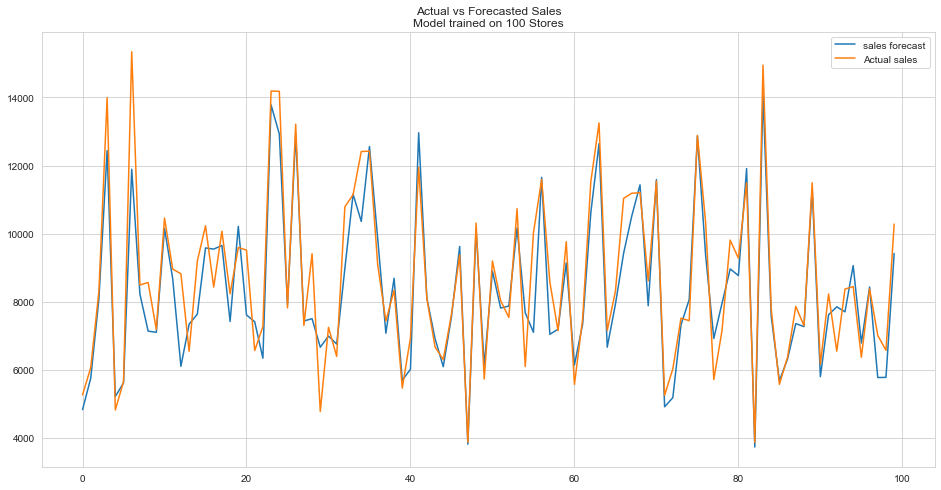

In [152]:
plt.figure(figsize=(16,8))
plt.plot(y_pred[:100],label = 'sales forecast')
plt.plot(y[:100],label = 'Actual sales')
plt.legend()
plt.title('Actual vs Forecasted Sales\nModel trained on 100 Stores')

#### 2.    Use Dropout for ANN and find the optimum number of clusters (clusters formed considering the features: sales and customer visits). Compare model performance with traditional ML based prediction models. 

In [153]:
train_data = train_data[train_data.Store<=100]
train_data = train_data[train_data.Open == 1]
train_data.reset_index(drop=True, inplace=True)

y = train_data['Sales']
x = train_data.drop(['Sales','Open'],axis=1)

std = StandardScaler()
x = std.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(np.array(x),np.array(y),random_state=42,test_size=0.3)

In [154]:
model_2 = Sequential()
model_2.add(layers.Dense(32, activation='elu', input_shape = (x_train.shape[1],)))
model_2.add(layers.Dense(64, activation='elu'))
model_2.add(layers.Dense(64, activation='elu'))
model_2.add(layers.BatchNormalization())

## block 2
model_2.add(layers.Dense(128, activation='elu'))
model_2.add(layers.Dense(128, activation='elu'))
model_2.add(layers.BatchNormalization())

## block 3
model_2.add(layers.Dense(256, activation='elu'))
model_2.add(layers.Dense(256, activation='elu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.8))

## block 4
model_2.add(layers.Dense(128, activation='elu'))
model_2.add(layers.Dense(128, activation='elu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.8))

## block 5
model_2.add(layers.Dense(64, activation='elu'))
model_2.add(layers.Dense(64, activation='elu'))
model_2.add(layers.Dense(32, activation='elu'))
model_2.add(layers.Dropout(0.8))
model_2.add(layers.Dense(1))

In [155]:
model_2.compile(loss='mse',
              optimizer = Adam(learning_rate=0.001),
              metrics=['mae'])

In [156]:
checkpoint = ModelCheckpoint('Sales_ann_with_dropout.h5',
                            monitor='loss',
                            mode=min,
                            save_best_only=True,
                            verbose=1)

early_stopping = EarlyStopping(monitor='loss',
                              patience=9,
                              min_delta=0,
                              restore_best_weights=True,
                              verbose=1)

Reduce_ler_rate = ReduceLROnPlateau(monitor='loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=1,
                                   min_delta=0.001)

callback = [checkpoint,early_stopping,Reduce_ler_rate]

In [157]:
history = model_2.fit(x_train,y_train,epochs=50,batch_size=20,verbose=1,callbacks=callback)

Epoch 1/50
2544/2552 [============================>.] - ETA: 0s - loss: 16398228.0000 - mae: 3228.0522
Epoch 00001: loss improved from inf to 16381824.00000, saving model to Sales_ann_with_dropout.h5
2552/2552 [==============================] - 7s 3ms/step - loss: 16381824.0000 - mae: 3226.1885
Epoch 2/50
2534/2552 [============================>.] - ETA: 0s - loss: 12938798.0000 - mae: 2782.3682
Epoch 00002: loss improved from 16381824.00000 to 12924422.00000, saving model to Sales_ann_with_dropout.h5
2552/2552 [==============================] - 7s 3ms/step - loss: 12924422.0000 - mae: 2780.5972
Epoch 3/50
2543/2552 [============================>.] - ETA: 0s - loss: 12470462.0000 - mae: 2722.1392
Epoch 00003: loss improved from 12924422.00000 to 12468093.00000, saving model to Sales_ann_with_dropout.h5
2552/2552 [==============================] - 7s 3ms/step - loss: 12468093.0000 - mae: 2721.7695
Epoch 4/50
2544/2552 [============================>.] - ETA: 0s - loss: 12054509.0000 - ma

In [158]:
model_2 = load_model('Sales_ann_with_dropout.h5')

y_pred = model_2.predict(x_test)
math.sqrt(mean_squared_error(y_test,y_pred))

1938.6130502881572

* When I used dropout root mean squared error increased.
* It is not useful for our model.

#### 3. Find the best setting of neural net that minimizes the loss and can predict the sales best. Use techniques like Grid search, cross-validation and Random search.

In [159]:
#cross validation

In [160]:
def modelkf(x_train,y_train,x_test,y_test):
        
    model = Sequential()
    model.add(layers.Dense(32, activation='elu', input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.BatchNormalization())

    ## block 2
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.BatchNormalization())

    ## block 3
    model.add(layers.Dense(256, activation='elu'))
    model.add(layers.Dense(256, activation='elu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.8))

    ## block 4
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.8))

    ## block 5
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(32, activation='elu'))
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(1))
    
    model.compile(loss='mse',
              optimizer = Adam(learning_rate=0.001),
              metrics=['mae'])
    
    model.fit(x_train,y_train,epochs=50,batch_size=20)
    
    y_pred = model.predict(x_test)
    
    return (math.sqrt(mean_squared_error(y_test,y_pred)))

In [164]:
score_kf_ann = []
kf = StratifiedKFold(n_splits=4,random_state=100)
for train_index,test_index in kf.split(x,y):
    x_train,x_test,y_train,y_test = train_test_split(np.array(x),np.array(y),test_size = 0.3,random_state=53)
    score_kf_ann.append(modelkf(x_train,y_train,x_test,y_test))

Epoch 1/50
2552/2552 [==============================] - 6s 2ms/step - loss: 17566532.0000 - mae: 3377.9365
Epoch 2/50
2552/2552 [==============================] - 6s 2ms/step - loss: 14413125.0000 - mae: 2977.6260
Epoch 3/50
2552/2552 [==============================] - 6s 2ms/step - loss: 13257686.0000 - mae: 2819.8572
Epoch 4/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12824226.0000 - mae: 2774.3896
Epoch 5/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12856587.0000 - mae: 2773.2393
Epoch 6/50
2552/2552 [==============================] - 7s 3ms/step - loss: 12702968.0000 - mae: 2742.2686
Epoch 7/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12494999.0000 - mae: 2728.3423
Epoch 8/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12321444.0000 - mae: 2702.2090
Epoch 9/50
2552/2552 [==============================] - 6s 3ms/step - loss: 12245067.0000 - mae: 2685.0029
Epoch 10/50
2552/2552 [==============

2552/2552 [==============================] - 6s 2ms/step - loss: 13585268.0000 - mae: 2863.9958
Epoch 4/50
2552/2552 [==============================] - 7s 3ms/step - loss: 13218924.0000 - mae: 2806.9775
Epoch 5/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12638703.0000 - mae: 2746.7881
Epoch 6/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12614963.0000 - mae: 2738.9614
Epoch 7/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12486517.0000 - mae: 2716.1177
Epoch 8/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12317018.0000 - mae: 2702.1919
Epoch 9/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12287008.0000 - mae: 2685.1597
Epoch 10/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12187813.0000 - mae: 2684.5249
Epoch 11/50
2552/2552 [==============================] - 6s 2ms/step - loss: 12022763.0000 - mae: 2661.8286
Epoch 12/50
2552/2552 [=======================

In [165]:
score_kf_ann

[67055.82603188697, 1705.5901814265628, 5139.764923450266, 2165.0387761147335]

In [168]:
RMSE = sum(score_kf_ann)/len(score_kf_ann)
RMSE

19016.554978219632

* Prediction is quite good in comparision to mean.